In [409]:
import cv2
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [410]:
img=cv2.imread("sudko.jpg")


# Resizing the image

In [411]:
def resizer(img):
    scale_percent = 60 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized
# print('Resized Dimensions : ',resized.shape)
 
cv2.imshow("Resized image", resizer(img))
cv2.waitKey(0)
cv2.destroyAllWindows()
 

(-0.5, 341.5, 441.5, -0.5)

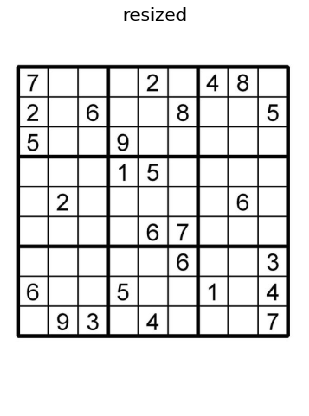

In [463]:

f = plt.figure(figsize=(18,23))
f.add_subplot(1,3, 3)
plt.imshow(resized)
plt.title('resized',fontsize=18)
plt.axis('off')

# Converting the resized image to gray and then bluring  and applying the Treshold. Futhermore Drawing the Contour to mark the biggest polygon

In [412]:
gray=cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
blur=cv2.GaussianBlur(gray,(9,9),0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
img,cont, hier = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
sort=sorted(cont,key=cv2.contourArea,reverse=True)
# img = cv2.drawContours(resized,sort,1,(255,255,0),2)
cv2.imshow("cont",img)
cv2.waitKey(0)
cv2.destroyAllWindows()


(-0.5, 341.5, 441.5, -0.5)

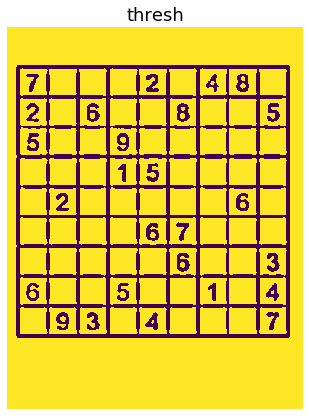

In [462]:
f = plt.figure(figsize=(18,23))
f.add_subplot(1,3, 3)
plt.imshow(thresh)
plt.title('thresh',fontsize=18)
plt.axis('off')

# Making index of the 4 corners of the polygon

In [414]:
biggest=sort[1]
# for i in biggest:
#     print(i[0][0],i[0][1]) ###x and y coordinate of all the pionnts of the  biggest polynomial
    
top_left,_=min(enumerate([i[0][0]+i[0][1] for i in biggest]),key=operator.itemgetter(1))
top_right,_=max(enumerate([i[0][0]-i[0][1] for i in biggest]),key=operator.itemgetter(1))
bottom_left,_=min(enumerate([i[0][0]-i[0][1] for i in biggest]),key=operator.itemgetter(1))
bottom_right,_=max(enumerate([i[0][0]+i[0][1] for i in biggest]),key=operator.itemgetter(1))
print(top_left) ##indices
print(top_right)
print(bottom_left)
print(bottom_right)

corner=biggest[top_left][0],biggest[top_right][0],biggest[bottom_right][0],biggest[bottom_left][0]
top_left,top_right,bottom_right,bottom_left=corner
print(top_left) ##values
print(top_right)
print(bottom_left)
print(bottom_right)

0
2
6
4
[10 44]
[325  43]
[ 12 360]
[327 358]


In [415]:
def distance(line1,line2):
    x=line2[0]-line1[0]
    y=line2[1]-line1[1]
    return np.sqrt((x**2)+(y**2))

 # Creating line

In [416]:
sides=max([distance(top_left,top_right),distance(top_right,bottom_right),distance(bottom_left,bottom_right),distance(top_left,bottom_left)])
source=np.array([top_left,top_right,bottom_right,bottom_left],np.float32)

# since we get the maximum side from the given image and now we are going to make the image to its perfect size using the maximum side

In [417]:
destination=np.array([(0,0),(sides-1,0),(sides-1,sides-1),(0,sides-1)],np.float32)
matrix1=cv2.getPerspectiveTransform(source,destination)
# it helps increating proper square shape

In [418]:
cropped=cv2.warpPerspective(thresh,matrix1,(int(sides),int(sides)))

# Reversing checking the image

In [403]:
ret,inv_matrix=cv2.invert(matrix1)
transformed_points = cv2.warpPerspective(cropped,inv_matrix, (width,height), cv2.WARP_INVERSE_MAP)

In [404]:
transformed_points.shape

(442, 342)

In [405]:
image=gray+transformed_points

In [406]:
cv2.imshow("cropped",image)
cv2.waitKey(0)
cv2.destroyAllWindows()


(-0.5, 315.5, 315.5, -0.5)

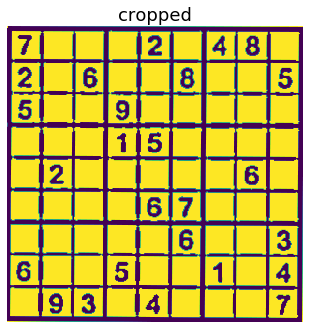

In [461]:
f = plt.figure(figsize=(18,23))
f.add_subplot(1,3, 3)
plt.imshow(cropped)
plt.title('cropped',fontsize=18)
plt.axis('off')

In [358]:
cv2.imshow("cropped",cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Making grid of all the small boxes

In [419]:
def gridcoordinates(square):
    cell_coordinate=np.zeros((81,4),np.float32)
    grid_size=square.shape[:1]
    cell=grid_size[0]/9
    k=0
    for i in range(9):
        for j in range(9):
            x1,y1=(i*cell,j*cell)
            x2,y2=((i+1)*cell,(j+1)*cell)
            cell_coordinate[k,:]=[x1,y1,x2,y2]
            k+=1
    return cell_coordinate
    
    
    
    
    

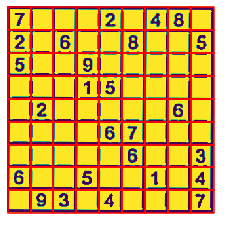

In [420]:
cell_coord=gridcoordinates(cropped)
plt.imshow(cropped)
for i in range(0,np.shape(cell_coord)[0]):
    x1, y1, x2, y2=cell_coord[i, :]
    x=[x1, x2, x2, x1, x1]
    y=[y1, y1, y2, y2, y1]
    plt.plot(x, y, 'r')
plt.axis('off')
#plt.savefig('grid.png', bbox_inches='tight')
plt.show()

    

In [421]:
coordinates=cell_coord.reshape(9,9,4)

In [422]:
def extraction(img,coord):
    x1, y1, x2, y2=coord
    dig=img[int(x1):int(x2), int(y1):int(y2)]# taking the value of coorsinates of a box
    dig3=cv2.resize(dig, (45, 45), interpolation=cv2.INTER_CUBIC)#resizing to the hight 45 and width 45
    digit=dig3/np.max(dig3)#scaling to makie the value between 0 and 1
    return digit

    

In [423]:
total_digit=np.zeros((81,45,45),np.float32)
for i in range(0,cell_coord.shape[0]):
    digit=extraction(cropped,cell_coord[i,:])
    total_digit[i,:,:]=digit

In [424]:

total_digit=total_digit.reshape(-1,45,45,1)

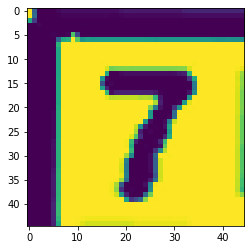

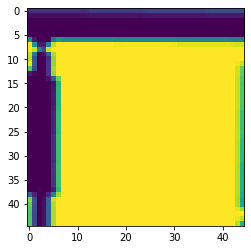

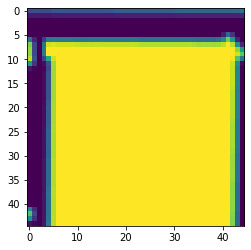

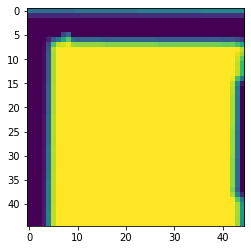

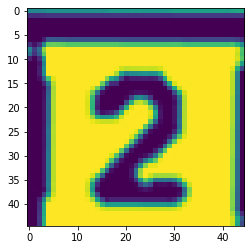

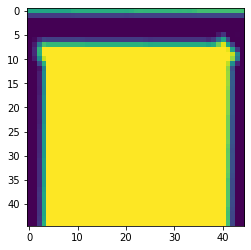

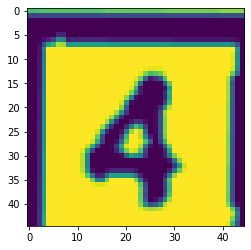

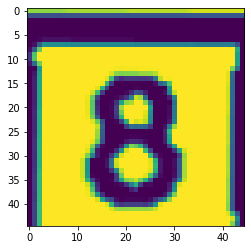

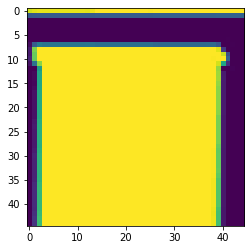

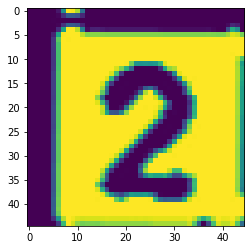

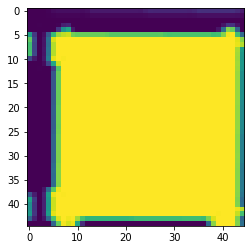

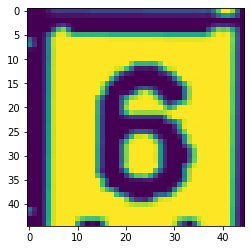

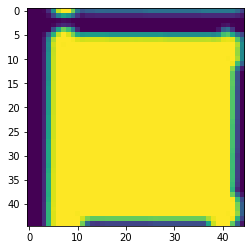

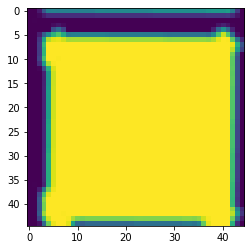

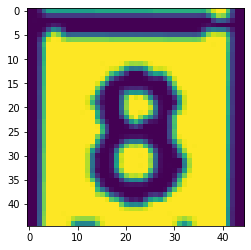

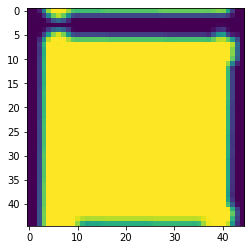

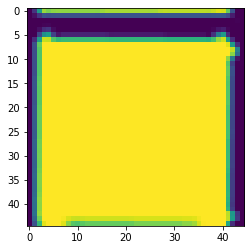

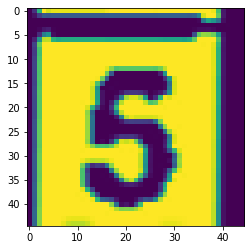

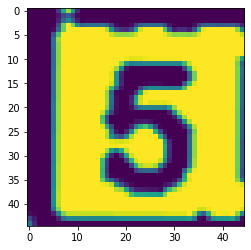

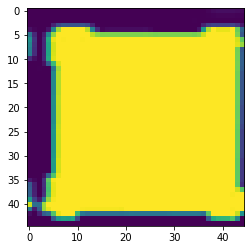

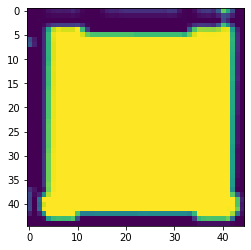

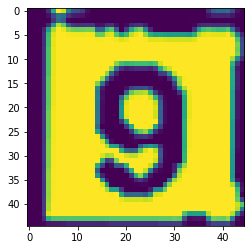

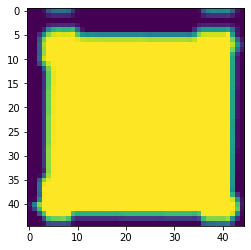

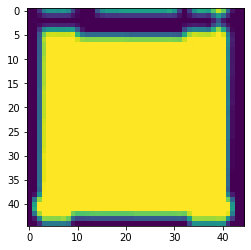

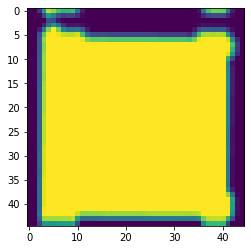

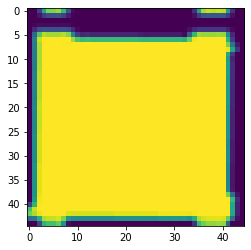

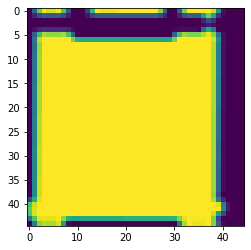

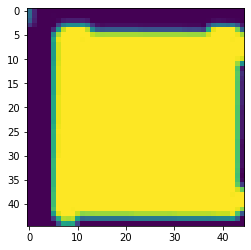

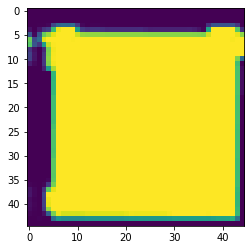

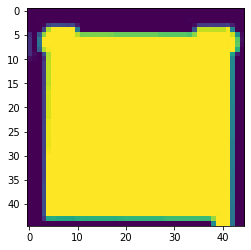

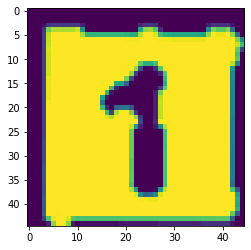

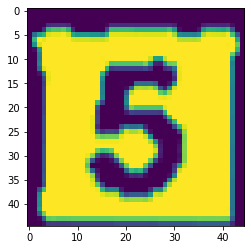

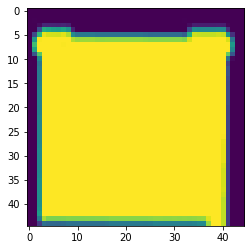

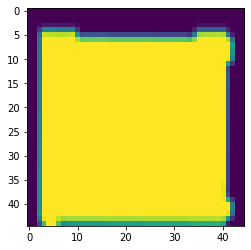

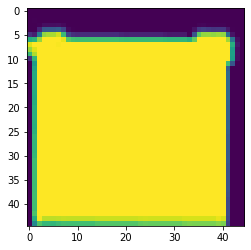

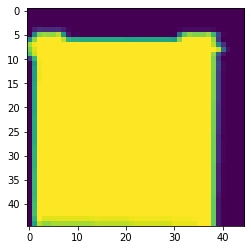

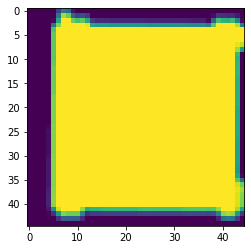

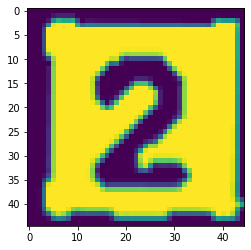

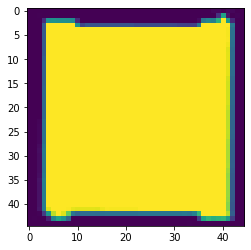

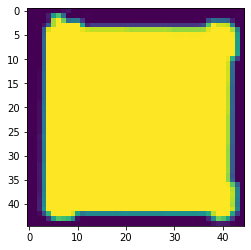

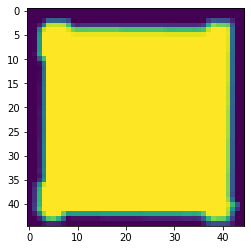

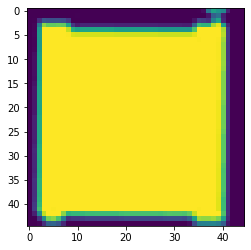

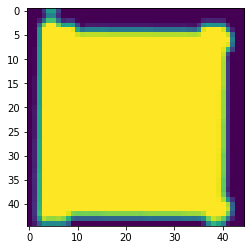

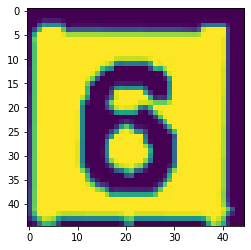

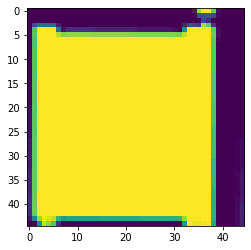

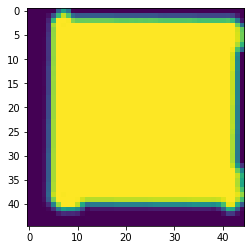

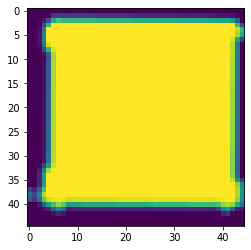

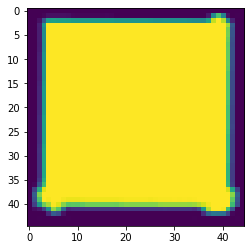

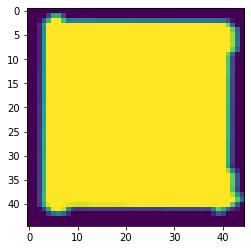

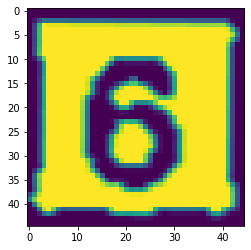

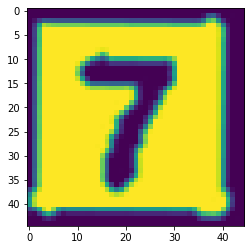

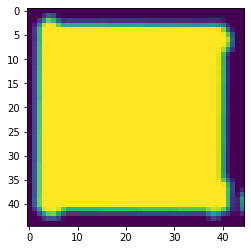

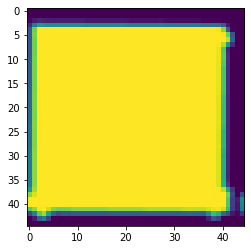

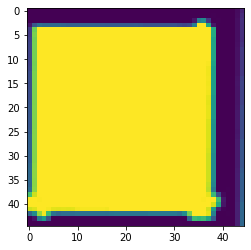

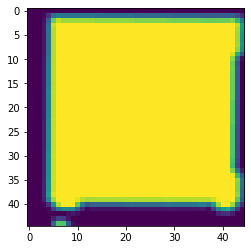

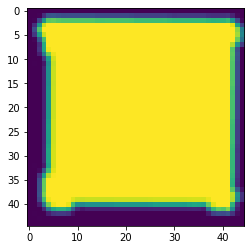

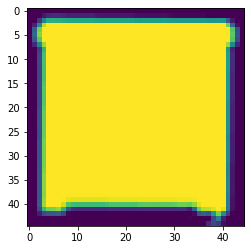

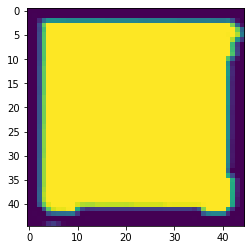

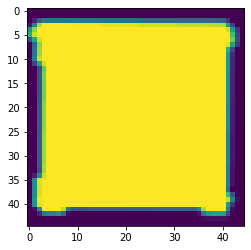

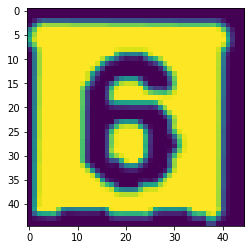

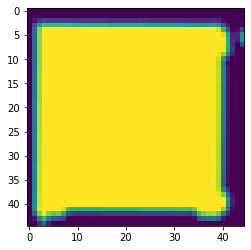

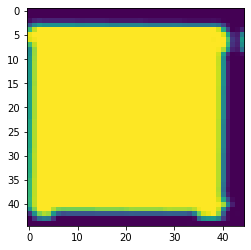

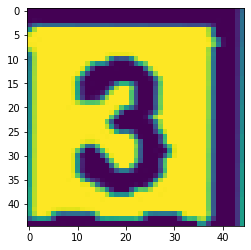

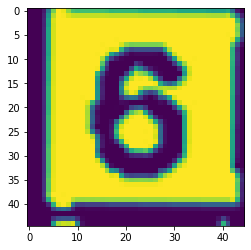

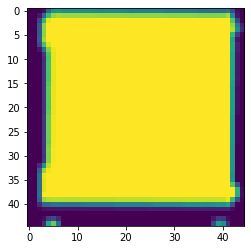

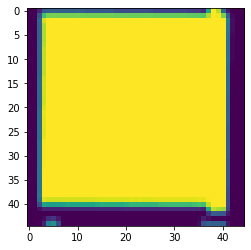

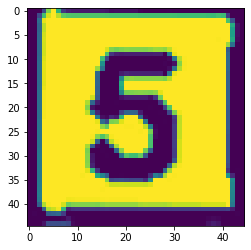

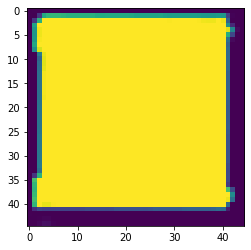

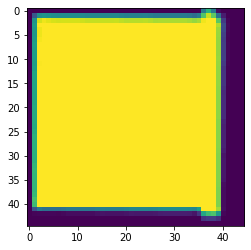

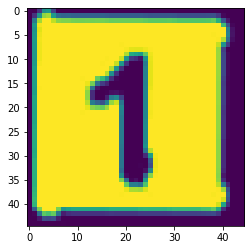

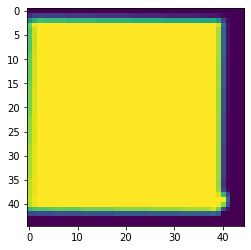

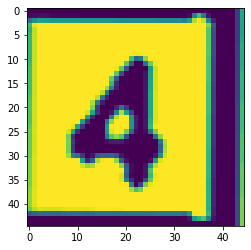

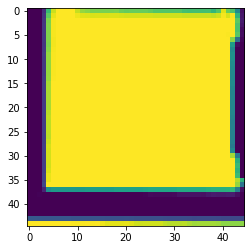

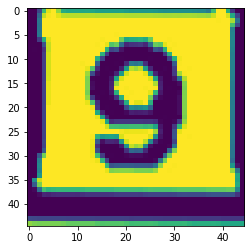

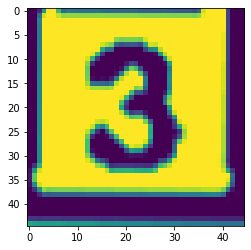

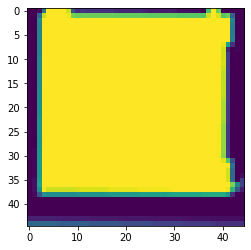

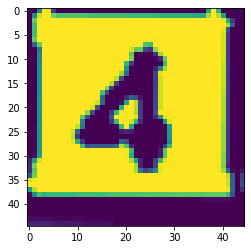

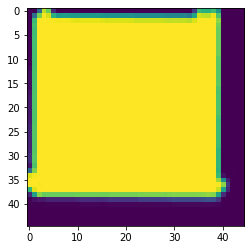

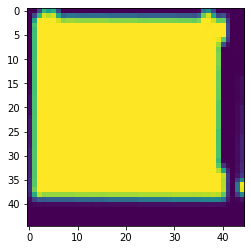

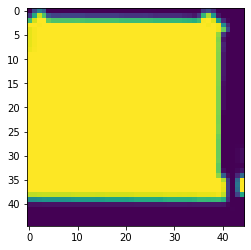

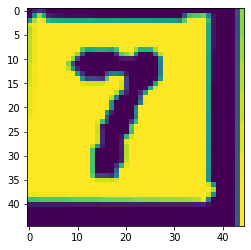

In [84]:
# for i in range(81):
#     plt.imshow(total_digit[i,:,:,0])
#     plt.show()

In [365]:
total_digit.shape

(81, 45, 45, 1)

In [426]:

total_digit=total_digit.reshape(-1,45,45,1)

# Saving image so thaat this samples is used for training

In [431]:
for i in range(81):
    
    gray=(total_digit[i])*255
    img_item = "newagainn"+str(i) + '.png'   
    cv2.imwrite(img_item,gray)
   



# Neural Network

In [425]:
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import mnist
from keras.utils import np_utils
import numpy as np
import cv2
from keras.models import load_model

In [427]:
import os
import numpy as np
from PIL import Image
import pickle
import cv2
import matplotlib.pyplot as plt

BASE_DIR= os.path.dirname(os.path.abspath("file")) 
image_dir=os.path.join(BASE_DIR,"image") 
recognizer= cv2.face.LBPHFaceRecognizer_create()
current_id=0
label_id={}
y_labels=[]
x_train=[]
for root,dirs,files in os.walk(image_dir):
    for file in files:
        if file.endswith("png"):
            path=os.path.join(root,file)
            label=os.path.basename(os.path.dirname(path)).replace(" ","_").lower()
        
#             print(label,path)
            
            if label in label_id:
                pass
            else:
                label_id[label]=current_id
                current_id+=1
            id_=label_id[label]  
#             print(label_id)
#           y_labels.append(label)
#           x_train.append(path)
            pil_image=Image.open(path).convert("L")#gray
            image=cv2.resize(np.uint8(pil_image),(45,45),interpolation=cv2.INTER_AREA)
            
#             plt.imshow(image)
#             plt.show()
            image_array=image.reshape(45,45,1)
#             image_array=np.reshape(image_array,(4096,))
#             print(image_array)
            x_train.append(image_array)
            y_labels.append(id_)
#             plt.imshow(image_array[:,:,0])
#             plt.show()
            
#print(y_labels)
# x_train=np.array(x_train)
x_train=np.array(x_train)
y_labels_orig=np.array(y_labels).reshape(len(y_labels))
print(x_train.shape)
print(y_labels_orig)

with open("labels.pickle","wb")as f:
    pickle.dump(label_id,f)

(251, 45, 45, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [428]:
number_of_classes = 10
Y_train = np_utils.to_categorical(y_labels_orig,number_of_classes)
X_train = x_train.astype('float32')


X_train/=255

In [429]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(X_train,Y_train,test_size=0.3)

In [430]:
train_x.shape

(175, 45, 45, 1)

In [431]:
test_y.shape

(76, 10)

In [40]:
# X1,y1,X2,y2=mnist.load()
# X1=X1.reshape(60000,28,28)
# X2=X2.reshape(10000,28,28)
# y_test=y2.reshape(-1,1)
# y_train=y1.reshape(-1,1)

# X_train=np.zeros((60000,45,45))
# for i in range(np.shape(X1)[0]):
#     X_train[i]=cv2.resize(X1[i], (45,45), interpolation = cv2.INTER_CUBIC)
    
# X_test=np.zeros((10000,45,45))
# for i in range(np.shape(X2)[0]):
#     X_test[i]=cv2.resize(X2[i], (45,45), interpolation = cv2.INTER_CUBIC)
# X_train=X_train.reshape(-1,45,45,1)  
 
# X_test=X_test.reshape(-1,45,45,1)  
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# X_train/=255
# X_test/=255
# number_of_classes = 10
# Y_train = np_utils.to_categorical(y_train,number_of_classes)
# Y_test = np_utils.to_categorical(y_test,number_of_classes)
# print("Xtrain done")

Xtrain done


In [432]:
hist=load_model("Newmodel_train.h5")

In [433]:
test_x.shape

(76, 45, 45, 1)

In [434]:
hist.predict(test_x).max()

1.0

In [435]:
pred=hist.predict(test_x)
pred=pred.argmax(1)

In [436]:
from sklearn.metrics import confusion_matrix

In [437]:
confusion_matrix(test_y.argmax(1),pred)

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  1,  0,  2,  0,  0,  1,  0],
       [ 0,  0,  3,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  1,  0,  3,  0,  1,  1,  0,  1,  0],
       [ 0,  1,  0,  1,  5,  5,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  4,  1,  0],
       [ 0,  1,  0,  0,  0,  0,  2,  0,  3,  0],
       [ 0,  3,  0,  0,  1,  0,  0,  0,  1,  1]])

In [438]:
pred=hist.predict(total_digit)
pred=pred.argmax(1)

In [439]:
pred

array([7, 0, 0, 0, 4, 0, 8, 6, 0, 4, 0, 5, 0, 0, 6, 0, 0, 1, 1, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 9, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5,
       0, 0, 0, 0, 0, 5, 7, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 3, 5, 0, 0,
       1, 0, 0, 9, 0, 8, 0, 2, 3, 0, 8, 0, 0, 0, 7])

In [440]:
def rearange_list(nlist):
    dlist=[]
    for i in range(0, 9):
        k=9*i
        l=k+9
        sub_list=nlist[k:l]
        dlist.append(sub_list)
    return np.matrix(dlist)

In [441]:
def prediction(pred):
    list_values=list(pred)
    matrix=rearange_list(list_values)
    matrix_p=np.copy(matrix)
    cache=[matrix,matrix_p]
    return cache


In [442]:
print(prediction(pred)[1])

[[7 0 0 0 4 0 8 6 0]
 [4 0 5 0 0 6 0 0 1]
 [1 0 0 2 0 0 0 0 0]
 [0 0 0 9 1 0 0 0 0]
 [0 4 0 0 0 0 0 5 0]
 [0 0 0 0 5 7 0 0 0]
 [0 0 0 0 0 5 0 0 3]
 [5 0 0 1 0 0 9 0 8]
 [0 2 3 0 8 0 0 0 7]]


# Backtracking

In [444]:
def verify_possile_value(x, y, n, grid):
    for i in range(0, 9):
        if grid[x, i]==n:
            return False
        
    for i in range(0, 9):
        if grid[i, y]==n:
            return False
    x0=(x//3)*3
    y0=(y//3)*3
    for i in range(0, 3):
        for j in range(0, 3):
            if grid[x0+i, y0+j]==n:
                return False
            
    return True



#fill in the empty slots:
def grid_solver(grid):
    for x in range(9):
        for y in range(9):
            if grid[x, y]==0:
                for n in range(1, 10):
                    if verify_possile_value(x, y, n, grid):
                        grid[x, y]=n
                        result=grid_solver(grid)
                        
                        if result is not None:
                            return result
                        
                        grid[x, y]=0 #Backtracking
                return None               
    return grid

In [445]:
result=grid_solver(prediction(pred)[0])
print(result)

[[7 3 2 5 4 1 8 6 9]
 [4 8 5 3 9 6 2 7 1]
 [1 6 9 2 7 8 4 3 5]
 [3 5 6 9 1 4 7 8 2]
 [9 4 7 8 3 2 1 5 6]
 [2 1 8 6 5 7 3 9 4]
 [8 9 1 7 2 5 6 4 3]
 [5 7 4 1 6 3 9 2 8]
 [6 2 3 4 8 9 5 1 7]]


In [446]:
matrix_p

array([[7, 0, 0, 0, 2, 0, 4, 8, 0],
       [2, 0, 6, 0, 0, 8, 0, 0, 5],
       [5, 0, 0, 9, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 5, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 6, 0],
       [0, 0, 0, 0, 6, 7, 0, 0, 0],
       [0, 0, 0, 0, 0, 6, 0, 0, 3],
       [6, 0, 0, 5, 0, 0, 1, 0, 4],
       [0, 9, 3, 0, 4, 0, 0, 0, 7]])

In [447]:
virtual_image=np.zeros((cropped.shape[0],cropped.shape[1],3),dtype=np.uint8)
font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(9):
    for j in range(9):
        if prediction(pred)[1][j,i]==0:
            number=result[j,i]
            corr=coordinates[i,j]
            xc=int((corr[0]+corr[2])/2)
            yc=int((corr[1]+corr[3])/2)
#             print(corr)
            cv2.putText(virtual_image,str(number),(xc-4,yc+4),font,0.7,(0,255,0),2)
cv2.imshow("vietual",virtual_image)  
cv2.waitKey(0)
cv2.destroyAllWindows()


(-0.5, 315.5, 315.5, -0.5)

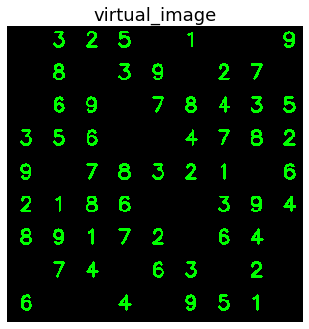

In [460]:
f = plt.figure(figsize=(18,23))
f.add_subplot(1,3, 3)
plt.imshow(virtual_image)
plt.title('virtual_image',fontsize=18)
plt.axis('off')

In [449]:
virtual_image.astype("int")
gray1=cv2.cvtColor(virtual_image,cv2.COLOR_BGR2GRAY)
vimg=cv2.warpPerspective(gray1,inv_matrix, (width,height), cv2.WARP_INVERSE_MAP)
gray2=cv2.cvtColor(vimg,cv2.COLOR_GRAY2BGR)

(-0.5, 341.5, 441.5, -0.5)

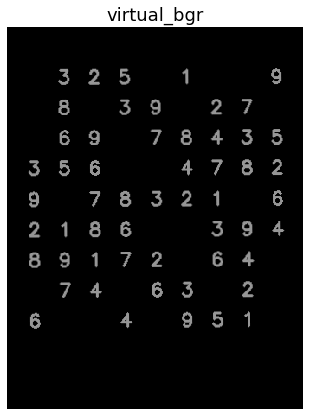

In [458]:
f = plt.figure(figsize=(18,23))
f.add_subplot(1,3, 3)
plt.imshow(gray2)
plt.title('virtual_bgr',fontsize=18)
plt.axis('off')

In [453]:
imgo = cv2.addWeighted(gray2,1,resized,0.8,0)
cv2.imshow("vietual",imgo)  
cv2.waitKey(0)
cv2.destroyAllWindows()

(-0.5, 341.5, 441.5, -0.5)

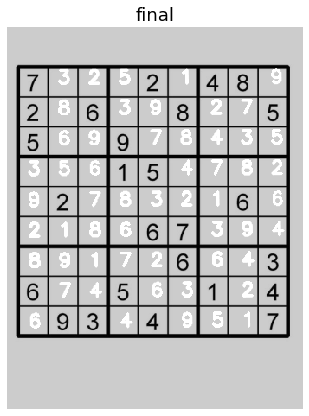

In [459]:
f = plt.figure(figsize=(18,23))
f.add_subplot(1,3, 3)
plt.imshow(imgo)
plt.title('final',fontsize=18)
plt.axis('off')